In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.ensemble._forest import RandomForestRegressor

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
    OneHotEncoder
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import Libs.preprocessors as pp

# Feature Engineering

In [59]:
df=pd.read_csv('data/train.csv')
features=pd.read_csv('output/selected_features.csv')

In [60]:
df['running']=df['running'].apply(lambda x: float(x.replace('km','')) if x[-2:]=='km' else float(x.replace('miles',''))*1.609344)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price','wheel'], axis=1), # predictive variables
    df['price'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1477, 8), (165, 8))

In [62]:
y_train=np.log(y_train)
y_test=np.log(y_test)

In [63]:
ONEHOTENCODER_VARS = ['model', 'motor_type','color','type']

TEMPORAL_VARS = ['year']

NUMERICALS_YEO_VARS = ["running", "motor_volume"]

QUAL_VARS = [
    'status']

qual_mappings = {'excellent': 3, 'good':2, 'crashed': 0, 'normal': 1, 'new': 4}

In [64]:
pipeline = Pipeline([

    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS)),

    # ===================== VARIABLE TRANSFORMATION ======================

    ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    


    # =========================== mappers ===============================
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=qual_mappings)),

    # == CATEGORICAL ENCODING
    ('one_hot_encoder', pp.CategoricalOneHotEncoder(
        variables=ONEHOTENCODER_VARS
    )),

    ('column_selector', pp.ColumnSelector(columns=features['0'].values)),

    ('ColumnsTRansformOHE',pp.MotorTypeTransformer()),

    ('scaler', MinMaxScaler()),
    ('selector', RandomForestRegressor(n_estimators=100,random_state=123)),
])

In [65]:
# train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('elapsed_time',
                 TemporalVariableTransformer(variables=['year'])),
                ('yeojohnson',
                 YeoJohnsonTransformer(variables=['running', 'motor_volume'])),
                ('mapper_qual',
                 Mapper(mappings={'crashed': 0, 'excellent': 3, 'good': 2,
                                  'new': 4, 'normal': 1},
                        variables=['status'])),
                ('one_hot_encoder',
                 CategoricalOneHotEncoder(variables=['model', 'motor_type',
                                                     'color',...
       'color_clove', 'color_golden', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_pink', 'color_purple',
       'color_red', 'color_silver', 'color_skyblue', 'color_white',
       'type_Coupe', 'type_Universal', 'type_hatchback', 'type_pickup',
       'type_sedan', 'type_suv'], dtype=object))),
                ('ColumnsTRansformOHE', MotorTypeTransformer()),
                ('scaler', MinMaxScaler()),
                ('selector', RandomForestRegressor(random_state=123))])

In [66]:
# evaluate the model:
# ====================

# make predictions for train set
pred = pipeline.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = pipeline.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 2467698
train rmse: 1570
train r2: 0.9531380707662824

test mse: 9876258
test rmse: 3142
test r2: 0.7570547717598506

Average house price:  15700


c:\Users\56953\Proyectos Python\Datapath ML\Modulo 2\ModeloMLDesp\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\56953\Proyectos Python\Datapath ML\Modulo 2\ModeloMLDesp\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [67]:
np.exp(y_test)

1572    18000.0
1417    15000.0
988     16300.0
1396    17500.0
1576    17500.0
         ...   
1175    17000.0
17      17500.0
440     15000.0
425      9000.0
52      17700.0
Name: price, Length: 165, dtype: float64

In [68]:
joblib.dump(pipeline, './Output/pipeline.joblib')

['./Output/pipeline.joblib']

<Axes: >

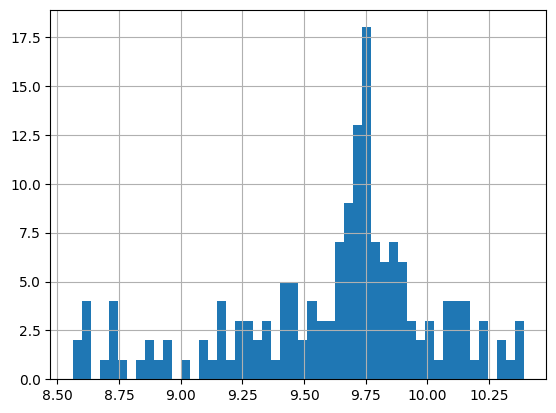

In [69]:
pd.Series(pred).hist(bins=50)